In [7]:
import time

import bp
import utils
#import models
import pickle
import plotters

import numpy as np
import pandas as pd
from scipy import stats

from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import MolFromSmiles
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD
from sklearn.neural_network import MLPRegressor
from sklearn.neural_network import MLPClassifier
from sklearn.utils.validation import column_or_1d
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import  MinMaxScaler, Normalizer, RobustScaler, StandardScaler

import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error

from rdkit.Chem import MolFromSmiles
from rdkit.Chem.rdReducedGraphs import GenerateErGFingerprintForReducedGraph
from rdkit.Chem import AllChem, rdReducedGraphs
from rdkit.Chem import DataStructs
from rdkit import rdBase
from rdkit.Chem import RDConfig

colors = ['#f25c9d', '#F2A25C', '#5B98A6', '#8BB63C']
path = 'e:/_phd/Docking_score/VDR/Data/'

In [2]:
df1 = pd.read_csv(path + "VDR_VDRML_ECR_plus_docking_results_plus_rank_1DB1_3KPZ.csv")
df2 = pd.read_csv(path + "VDR_actives_decoys_ECR_plus_docking_results_plus_rank_1DB1_3KPZ.csv")
df = pd.concat([df1, df2])
names = df.columns[2:].to_list()
names = ['id', 'smi', 'label', 'active'] + names

df = df.rename(columns={'smiles': 'smi'})
#df['log10_1PQ6'] = (np.log10(df.ECR_1PQ6))
#df['log10_1P8D'] = (np.log10(df.ECR_1P8D)) 




In [3]:
min_max_scaler = MinMaxScaler()

In [4]:
a = df.id.str[:3]
df['label'] =  np.where(a == 'VDR', 1, np.where(a == 'CHE', 2, 3))
x = (df.ECR_3KPZ!=0.0).to_list()
y = (df.ECR_1DB1!=0.0).to_list()

df['active'] =  x and y
names_ds = [n for n in names if 'rank' not in n]

df = df[names_ds]
names_ds = names_ds[6:]

#df[names_ds] = min_max_scaler.fit_transform(df[names_ds])
#df = df[df.ECR_3KPZ!=0.0]

# outliers
for i in range(len(names_ds)):
    z = np.abs(stats.zscore(df[names_ds[i]]))
    df = df[(z < 2.8)] 

df.shape

(15928, 16)

In [5]:
df['ECR_1DB1_cats'] = pd.qcut(df['ECR_1DB1'], 5, labels=[1, 2, 3, 4, 5])
df['ECR_3KPZ_cats'] = pd.qcut(df['ECR_3KPZ'], 5, labels=[1, 2, 3, 4, 5])
cols = df.columns.to_list()
cols = cols[:6] + cols[-2:] + cols[6:-2]
df = df[cols]
cols_1DB1 = [n for n in cols if '1DB1' in n]
cols_1DB1 = ['id', 'smi'] + cols_1DB1
cols_3KPZ = [n for n in cols if '3KPZ' in n]
cols_3KPZ = ['id', 'smi'] + cols_3KPZ
df_1DB1 = df[cols_1DB1]
df_3KPZ = df[cols_3KPZ]
df_3KPZ.head()

,id,smi,ECR_3KPZ,ECR_3KPZ_cats,docking_score_CHEMPLP_3KPZ,docking_score_london_3KPZ,docking_score_ASE_3KPZ,docking_score_AHB_3KPZ,docking_score_AdG_3KPZ
53,VDRML12443,O(CC(O)C(C)(C)C)c1ccc(cc1C)C(CC)(CC)c1cc(C)c(O...,1.266485e-08,5,-18.5023,-15.833379,-34.672565,-134.60599,-6.582305
55,VDRML10013,O(c1ccc(cc1C)C(O)(C)c1cc(C)c(OC(CCO)CO)cc1)c1c...,1.866916e-49,4,-14.4823,-14.465381,-34.617458,-110.39362,-5.018876
59,VDRML22932,FC(F)(F)c1cc(cc(c1)C(CC)=CCCC(O)C(F)(F)F)-c1cc...,5.510139e-41,4,-19.2404,-14.621018,-29.102003,-125.37780,-8.237293
61,VDRML5897,O(C(C)c1cc(C)c(OCC(C(O)CCO)C)cc1)c1ccc(cc1C)C(...,2.598945e-61,3,-18.4980,-14.088391,-34.145546,-122.28143,-6.665919
62,VDRML961,O1Cc2c(cc(cc2)COc2cc(C)c(cc2)Cc2ccc(cc2CCC)C(C...,7.058884e-22,5,-16.5118,-15.118000,-33.256104,-101.87988,-7.457160


In [41]:
# CLASSIFICATION TO ECR categories, Bayesian optimalization

In [11]:
x = utils.morgan(df)
svd = TruncatedSVD(600) #90 % of variance covered by 500 components
transformed = svd.fit_transform(x)
print(svd.explained_variance_ratio_.sum())

df_1DB1['x'] = x

0.9204301861070092


C:\Users\kamcl\Miniconda3\envs\multistep_ml\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [13]:
pca = PCA(0.9)
pca.fit(df_1DB1['x'].to_list())
morg_pca = pca.transform(df_1DB1['x'].to_list()) 

In [15]:
mols = [Chem.MolFromSmiles(mol) for mol in list(df_1DB1['smi'])]
ergfps = [rdReducedGraphs.GetErGFingerprint( mol ) for mol in mols]

In [17]:
concat_fps = np.concatenate((ergfps, morg_pca), 1)
df_1DB1['concat_fps'] = [x for x in concat_fps]

C:\Users\kamcl\Miniconda3\envs\multistep_ml\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
# Splitting the data for test and train

In [ ]:
y = np.array(df_1DB1['ECR_1DB1_cats'], dtype=np.float32).ravel()

trainX, testX, trainY, testY = train_test_split(
        df_1DB1[:,4:9], y, test_size=0.2, random_state=1)

In [19]:
df_1DB1

,id,smi,ECR_1DB1,ECR_1DB1_cats,docking_score_CHEMPLP_1DB1,docking_score_london_1DB1,docking_score_ASE_1DB1,docking_score_AHB_1DB1,docking_score_AdG_1DB1,x,concat_fps
53,VDRML12443,O(CC(O)C(C)(C)C)c1ccc(cc1C)C(CC)(CC)c1cc(C)c(O...,5.263170e-04,5,-139.3930,-16.605047,-36.741856,-124.033010,-6.329831,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.3, 1.0, 0.3, 0.0, 0.0, 0.0, ..."
55,VDRML10013,O(c1ccc(cc1C)C(O)(C)c1cc(C)c(OC(CCO)CO)cc1)c1c...,3.697864e-04,5,-113.1010,-16.571434,-34.766598,-104.053540,-3.879936,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.3, 1.0, 0.3, 0.3, 1.3, 1.3, ..."
59,VDRML22932,FC(F)(F)c1cc(cc(c1)C(CC)=CCCC(O)C(F)(F)F)-c1cc...,2.478752e-04,5,-107.1980,-16.514418,-29.382847,-118.534110,-7.638307,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
61,VDRML5897,O(C(C)c1cc(C)c(OCC(C(O)CCO)C)cc1)c1ccc(cc1C)C(...,2.029431e-04,5,-113.9770,-16.482901,-35.892986,-112.810070,-7.639596,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.3, 1.0, 0.3, 0.0, 0.0, 0.0, 0.0, ..."
62,VDRML961,O1Cc2c(cc(cc2)COc2cc(C)c(cc2)Cc2ccc(cc2CCC)C(C...,1.836305e-04,5,-121.1900,-16.478628,-35.586884,-98.647942,-6.188746,"[0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...,...,...,...,...,...
2017,C82344328,O=C(NCC#C)N1C[C@H](CCC1)C,1.520310e-47,4,-72.0498,-7.726195,-20.134851,-70.489876,-4.607591,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2018,C95887349,ClC(Cl)(Cl)C=1N=C2[C@H](N=1)C=CC=C2,2.062842e-49,4,-65.5789,-7.709933,-14.323812,-67.376793,-4.369405,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2023,C39961264,Brc1ccc(nc1F)N1CCCC1,3.314257e-39,4,-73.0001,-7.555915,-18.885298,-68.328430,-5.340286,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2025,C86815921,s1cc(C=2OC(=S)NN=2)c(c1)C,1.693284e-50,4,-64.7367,-7.431933,-14.249882,-68.330101,-4.242002,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [18]:
'''
train_set = df_1DB1.sample(frac=0.8, random_state=1)
test_set = df_1DB1.drop(train_set.index)

trainX = train_set.iloc[:,4:-1]
trainY = train_set.ECR_1DB1_cats.to_list()
testX = test_set.iloc[:,4:-1]
testY = test_set.ECR_1DB1_cats.to_list()
'''

In [8]:
def dataset_loss(params):
    return cross_val_score(RandomForestClassifier(n_estimators=params[0], max_depth=params[1], random_state=1),
                           X=trainX, y=trainY, scoring='accuracy', cv=3, verbose=True).mean()

In [146]:
lambdas = np.arange(550, 750, 100)
gammas = np.arange(14, 17, 1)

# We need the cartesian combination of these two vectors
param_grid = np.array([[C, gamma] for gamma in gammas for C in lambdas])

real_loss = [dataset_loss(params) for params in param_grid]

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   32.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   38.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   34.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   40.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   35.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   41.0s finished


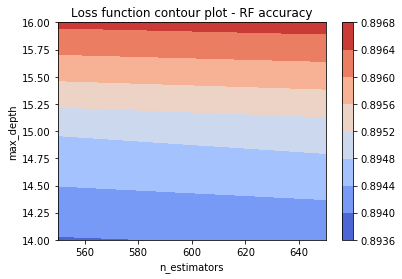

In [147]:
import matplotlib.cm as cm


C, G = np.meshgrid(lambdas, gammas)
plt.figure()
cp = plt.contourf(C, G, np.array(real_loss).reshape(C.shape), cmap=cm.coolwarm)
m = plt.cm.ScalarMappable(cmap=cm.coolwarm)
plt.colorbar(cp)
plt.title('Loss function contour plot - RF accuracy')
plt.xlabel('n_estimators')
plt.ylabel('max_depth')
#plt.savefig('loss_contour_RFacc_04_test.png', bbox_inches='tight')
plt.show()

In [150]:
np.array(real_loss).reshape(C.shape), C

(array([[0.89397235, 0.89405089],
        [0.89483574, 0.89499268],
        [0.89648383, 0.89656236]]), array([[550, 650],
        [550, 650],
        [550, 650]]))

In [149]:
real_loss

[0.8939723487100899,
 0.8940508909135816,
 0.8948357401871947,
 0.8949926767848092,
 0.8964838331285434,
 0.8965623568558642]

In [ ]:
#bayesian_optimisation

In [127]:
RF = RandomForestClassifier(n_estimators=700, max_depth=15, random_state=1)
RF.fit(trainX, trainY)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=15, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=700,
                       n_jobs=None, oob_score=False, random_state=1, verbose=0,
                       warm_start=False)

In [120]:
RF = RandomForestClassifier(n_estimators=400, max_depth=30, random_state=1)
RF.fit(trainX, trainY)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=30, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=400,
                       n_jobs=None, oob_score=False, random_state=1, verbose=0,
                       warm_start=False)

In [128]:
cvs = cross_val_score(RF, X=testX, y=testY, scoring='accuracy', cv=10, verbose=True)
cvs

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   22.9s finished


array([0.37593985, 0.96616541, 0.96240602, 0.9924812 , 0.97368421,
       1.        , 0.9887218 , 0.93233083, 0.89097744, 0.60377358])

In [129]:
cvs.mean()

0.8686480351822954

In [124]:
cvs.mean()

0.8682720953326714

In [65]:
from sklearn.svm import SVC
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score


# predicted scores
#testX = df_pred_1DB1.iloc[:,4:]
#testY = df_pred_1DB1.ECR_1DB1_cats.to_list()

model = RF
predictions = model.predict(testX)
tracc = ("Train Accuracy:", accuracy_score(trainY, model.predict(trainX)), '\n')
teacc =  ("Test Accuracy:", accuracy_score(testY, model.predict(testX)), '\n')
print(tracc, teacc)
print(classification_report(testY, predictions))

('Train Accuracy:', 0.9978025427719354, '\n') ('Test Accuracy:', 0.9631440391124483, '\n')
              precision    recall  f1-score   support

           1       0.96      0.98      0.97       610
           2       0.96      0.98      0.97       648
           3       0.98      1.00      0.99       647
           4       0.96      0.95      0.96       465
           5       0.94      0.82      0.87       289

    accuracy                           0.96      2659
   macro avg       0.96      0.95      0.95      2659
weighted avg       0.96      0.96      0.96      2659



Text(0.5, 1.0, 'Test set')

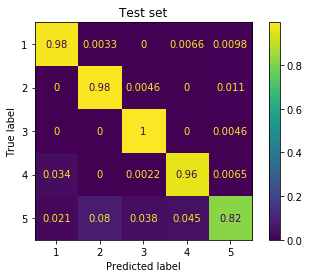

In [102]:
from sklearn.metrics import plot_confusion_matrix
from matplotlib.pyplot import plot as plt

disp = plot_confusion_matrix(RF, testX, testY,
                                                display_labels=['1','2','3','4', '5'],
                                                normalize='true')
disp.ax_.set_title('Test set')

In [9]:
""" plotters.py
"""
import matplotlib.cm as cm
import matplotlib.pyplot as plt
file_path = path

def plot_iteration(first_param_grid, sampled_params, sampled_loss, first_iter=0, alpha=1e-5,
                   greater_is_better=True, true_y=None, second_param_grid=None,
                   param_dims_to_plot=[0, 1], filepath=None, optimum=None):
    """ plot_iteration
    Plots a line plot (1D) or heatmap (2D) of the estimated loss function and expected
    improvement acquisition function for each iteration of the Bayesian search algorithm.
    Arguments:
    ----------
        first_param_grid: array-like, shape = [n, 1]
            Array containing the grid of points to plot for the first parameter.
        sampled_params: array-like, shape = [n_points, n_params]
            Points for which the value of the loss function is computed.
        sampled_loss: function.
            Values of the loss function for the parameters in `sampled_params`.
        first_iter: int.
            Only plot iterations after the `first_iter`-th iteration.
        alpha: float
            Variance of the error term in the GP model.
        greater_is_better: boolean
            Boolean indicating whether we want to maximise or minimise the loss function.
        true_y: array-like, shape = [n, 1] or None
            Array containing the true value of the loss function. If None, the real loss
            is not plotted. (1-dimensional case)
        second_param_grid: array-like, shape = [n, 1]
            Array containing the grid of points to plot for the second parameter, in case
            of a heatmap.
        param_dims_to_plot: list of length 2
            List containing the indices of `sampled_params` that contain the first and
            second parameter.
        optimum: array-like [1, n_params].
            Maximum value of the loss function.
    """

    # Create the GP
    kernel = gp.kernels.Matern()
    model = gp.GaussianProcessRegressor(kernel=kernel,
                                        alpha=alpha,
                                        n_restarts_optimizer=10,
                                        normalize_y=True)

    # Don't show the last iteration (next_sample is not available then)
    for i in range(first_iter, sampled_params.shape[0] - 1):
        model.fit(X=sampled_params[:(i + 1), :], y=sampled_loss[:(i + 1)])

        if second_param_grid is None:
            # 1-dimensional case: line plot
            mu, std = model.predict(first_param_grid[:, np.newaxis], return_std=True)
            ei = -1 * expected_improvement(first_param_grid, model, sampled_loss[:(i + 1)],
                                           greater_is_better=greater_is_better, n_params=1)

            fig, ax1, ax2 = _plot_loss_1d(first_param_grid, sampled_params[:(i + 1), :], sampled_loss[:(i + 1)], mu, std, ei, sampled_params[i + 1, :], yerr=alpha, true_y=true_y)
        else:
            # Transform grids into vectors for EI evaluation
            param_grid = np.array([[first_param, second_param] for first_param in first_param_grid for second_param in second_param_grid])

            mu, std = model.predict(param_grid, return_std=True)
            ei = -1 * expected_improvement(param_grid, model, sampled_loss[:(i + 1)],
                                           greater_is_better=greater_is_better, n_params=2)

            fig, ax2 = _plot_loss_2d(first_param_grid, second_param_grid, sampled_params[:(i+1), param_dims_to_plot], sampled_loss, mu, ei, sampled_params[i + 1, param_dims_to_plot], optimum)

        if file_path is not None:
            plt.savefig('%s/bo_iteration_%d.png' % (path, i), bbox_inches='tight')


def _plot_loss_1d(x_grid, x_eval, y_eval, mu, std, ei, next_sample, yerr=0.0, true_y=None):
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8,8), sharex=True)

    # Loss function plot
    ax1.plot(x_grid, mu, label = "GP mean")
    ax1.fill_between(x_grid, mu - std, mu + std, alpha=0.5)
    ax1.errorbar(x_eval, y_eval, yerr, fmt='ok', zorder=3, label="Observed values")
    ax1.set_ylabel("Function value f(x)")
    ax1.set_xlabel("x")

    if true_y is not None:
        ax1.plot(x_grid, true_y, '--', label="True function")

    # Acquisition function plot
    ax2.plot(x_grid, ei, 'r', label="Expected improvement")
    ax2.set_ylabel("Expected improvement (EI)")
    ax2.set_title("Next sample point is C = %.3f" % next_sample)
    ax2.axvline(next_sample)

    return fig, ax1, ax2


def _plot_loss_2d(first_param_grid, second_param_grid, sampled_params, sampled_loss, mu, ei, next_sample, optimum=None):

    #fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8,8), sharex=True, sharey=True)
    fig, ax2 = plt.subplots(1, 1, figsize=(8,4), sharex=True, sharey=True)

    X, Y = np.meshgrid(first_param_grid, second_param_grid, indexing='ij')
    
    '''
    # EI contour plot
    cp = ax1.contourf(X, Y, ei.reshape(X.shape))
    plt.colorbar(cp, ax=ax1)
    ax1.set_title("Expected Improvement. Next sample will be (%.2f, %.2f)" % (next_sample[0], next_sample[1]))
    ax1.autoscale(False)
    ax1.axvline(next_sample[0], color='k')
    ax1.axhline(next_sample[1], color='k')
    ax1.scatter(next_sample[0], next_sample[1])
    ax1.set_xlabel("C")
    ax1.set_ylabel("gamma")
    '''

    # Loss contour plot
    cp2 = ax2.contourf(X, Y, mu.reshape(X.shape), cmap=cm.coolwarm)
    plt.colorbar(cp2, ax=ax2)
    ax2.autoscale(False)
    ax2.scatter(sampled_params[:, 0], sampled_params[:, 1], zorder=1)
    ax2.axvline(next_sample[0], color='k')
    ax2.axhline(next_sample[1], color='k')
    ax2.scatter(next_sample[0], next_sample[1])
    ax2.set_title("GP  mean of loss for iteration %d" % (sampled_params.shape[0]))
    ax2.set_xlabel("# estimators")
    ax2.set_ylabel("depth")

    if optimum is not None:
        ax2.scatter(optimum[0], optimum[1], marker='*', c='gold', s=150)

    return fig, ax2

In [10]:
""" gp.py
Bayesian optimisation of loss functions.
"""

import numpy as np
import sklearn.gaussian_process as gp

from scipy.stats import norm
from scipy.optimize import minimize

def expected_improvement(x, gaussian_process, evaluated_loss, greater_is_better=True, n_params=1):
    """ expected_improvement
    Expected improvement acquisition function.
    Arguments:
    ----------
        x: array-like, shape = [n_samples, n_hyperparams]
            The point for which the expected improvement needs to be computed.
        gaussian_process: GaussianProcessRegressor object.
            Gaussian process trained on previously evaluated hyperparameters.
        evaluated_loss: Numpy array.
            Numpy array that contains the values off the loss function for the previously
            evaluated hyperparameters.
        greater_is_better: Boolean.
            Boolean flag that indicates whether the loss function is to be maximised or minimised.
        n_params: int.
            Dimension of the hyperparameter space.
    """

    x_to_predict = x.reshape(-1, n_params)

    mu, sigma = gaussian_process.predict(x_to_predict, return_std=True)
   # print(evaluated_loss, np.max(evaluated_loss), np.min(evaluated_loss))
    if greater_is_better:        
        loss_optimum = np.max(evaluated_loss)
    else:
        loss_optimum = np.min(evaluated_loss)
        
    

    scaling_factor = (-1) ** (not greater_is_better)

    # In case sigma equals zero
    with np.errstate(divide='ignore'):
        Z = scaling_factor * (mu - loss_optimum) / sigma
        expected_improvement = scaling_factor * (mu - loss_optimum) * norm.cdf(Z) + sigma * norm.pdf(Z)
        expected_improvement[sigma == 0.0] == 0.0

    #print(loss_optimum, -1 * expected_improvement)
    return -1 * expected_improvement


def sample_next_hyperparameter(acquisition_func, gaussian_process, evaluated_loss, greater_is_better=False,
                               bounds=(0, 10), n_restarts=25):
    """ sample_next_hyperparameter
    Proposes the next hyperparameter to sample the loss function for.
    Arguments:
    ----------
        acquisition_func: function.
            Acquisition function to optimise.
        gaussian_process: GaussianProcessRegressor object.
            Gaussian process trained on previously evaluated hyperparameters.
        evaluated_loss: array-like, shape = [n_obs,]
            Numpy array that contains the values off the loss function for the previously
            evaluated hyperparameters.
        greater_is_better: Boolean.
            Boolean flag that indicates whether the loss function is to be maximised or minimised.
        bounds: Tuple.
            Bounds for the L-BFGS optimiser.
        n_restarts: integer.
            Number of times to run the minimiser with different starting points.
    """
    best_x = None
    best_acquisition_value = 1
    n_params = bounds.shape[0]

    for starting_point in np.random.uniform(bounds[:, 0], bounds[:, 1], size=(n_restarts, n_params)):

        res = minimize(fun=acquisition_func,
                       x0=starting_point.reshape(1, -1),
                       bounds=bounds,
                       method='L-BFGS-B',
                       args=(gaussian_process, evaluated_loss, greater_is_better, n_params))
        
        print(res.fun, best_acquisition_value)

        if res.fun < best_acquisition_value:
            best_acquisition_value = res.fun
            best_x = res.x

    return best_x


def bayesian_optimisation(n_iters, sample_loss, bounds, x0=None, n_pre_samples=5,
                          gp_params=None, random_search=False, alpha=1e-5, epsilon=1e-7):
    
    """ bayesian_optimisation
    Uses Gaussian Processes to optimise the loss function `sample_loss`.
    Arguments:
    ----------
        n_iters: integer.
            Number of iterations to run the search algorithm.
        sample_loss: function.
            Function to be optimised.
        bounds: array-like, shape = [n_params, 2].
            Lower and upper bounds on the parameters of the function `sample_loss`.
        x0: array-like, shape = [n_pre_samples, n_params].
            Array of initial points to sample the loss function for. If None, randomly
            samples from the loss function.
        n_pre_samples: integer.
            If x0 is None, samples `n_pre_samples` initial points from the loss function.
        gp_params: dictionary.
            Dictionary of parameters to pass on to the underlying Gaussian Process.
        random_search: integer.
            Flag that indicates whether to perform random search or L-BFGS-B optimisation
            over the acquisition function.
        alpha: double.
            Variance of the error term of the GP.
        epsilon: double.
            Precision tolerance for floats.
    """

    x_list = []
    y_list = []

    n_params = bounds.shape[0]

    if x0 is None:
        for params in np.random.uniform(bounds[:, 0], bounds[:, 1], (n_pre_samples, bounds.shape[0])):
            x_list.append(params.astype(int))
            y_list.append(sample_loss(params.astype(int)))
    else:
        for params in x0:
            x_list.append(params.astype(int))           
            y_list.append(sample_loss(params.astype(int)))

    xp = np.array(x_list)
    yp = np.array(y_list)

    # Create the GP
    if gp_params is not None:
        model = gp.GaussianProcessRegressor(**gp_params)
    else:
        kernel = gp.kernels.Matern()
        model = gp.GaussianProcessRegressor(kernel=kernel,
                                            alpha=alpha,
                                            n_restarts_optimizer=10,
                                            normalize_y=True)

    for n in range(n_iters):

        model.fit(xp, yp)

        # Sample next hyperparameter
        if random_search:
            x_random = np.random.uniform(bounds[:, 0], bounds[:, 1], size=(random_search, n_params)).astype(int)
            ei = -1 * expected_improvement(x_random, model, yp, greater_is_better=False, n_params=n_params)
            next_sample = x_random[np.argmax(ei), :]
        else:
            next_sample = sample_next_hyperparameter(expected_improvement, model, yp, 
                                                     greater_is_better=True, bounds=bounds, n_restarts=100)

        # Duplicates will break the GP. In case of a duplicate, we will randomly sample a next query point.
        if np.any(np.abs(next_sample - xp) <= epsilon):
            next_sample = np.random.uniform(bounds[:, 0], bounds[:, 1], bounds.shape[0]).astype(int)

        # Sample loss for new set of parameters
        cv_score = sample_loss(next_sample)

        # Update lists
        x_list.append(next_sample)
        y_list.append(cv_score)

        # Update xp and yp
        xp = np.array(x_list)
        yp = np.array(y_list)

    return xp, yp

In [45]:
bounds = np.array([[10, 1500], [1, 30]])

xp, yp = bayesian_optimisation(n_iters=30, 
                               sample_loss=dataset_loss, 
                               bounds=bounds,
                               n_pre_samples=3,
                               random_search=1000000)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   58.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    8.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   18.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   30.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   11.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

In [133]:
import imageio
images = []

for i in range(7, 35):
    filename = path+"bo_iteration_%d.png" % i 
    images.append(imageio.imread(filename))
    
imageio.mimsave(path+'contour_plot.gif', images, duration=1.0)

C:\Users\kamcl\Miniconda3\envs\multistep_ml\lib\site-packages\ipykernel_launcher.py:97: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
C:\Users\kamcl\Miniconda3\envs\multistep_ml\lib\site-packages\ipykernel_launcher.py:97: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
C:\Users\kamcl\Miniconda3\envs\multistep_ml\lib\site-packages\ipykernel_launcher.py:97: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory.

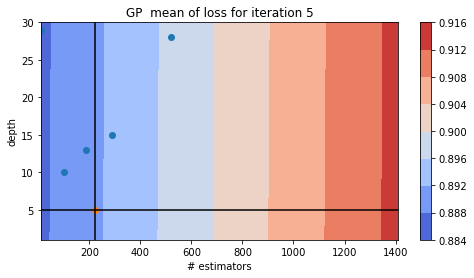

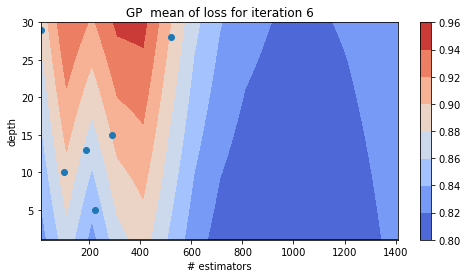

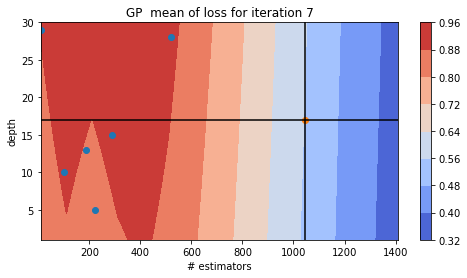

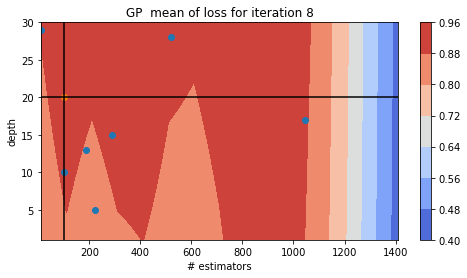

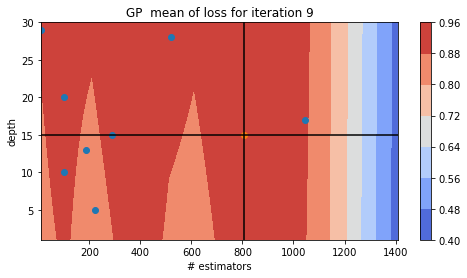

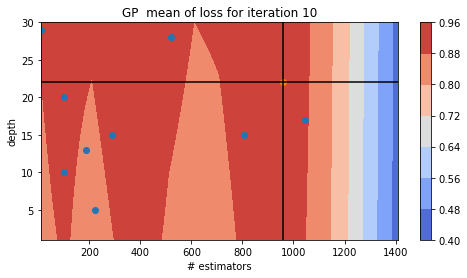

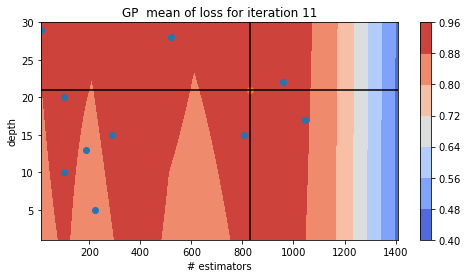

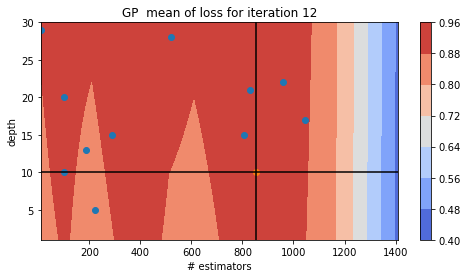

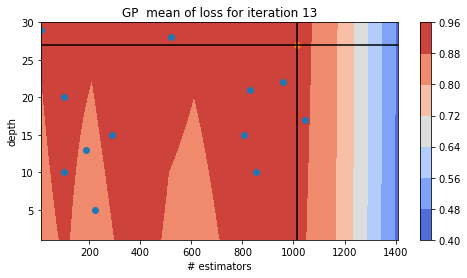

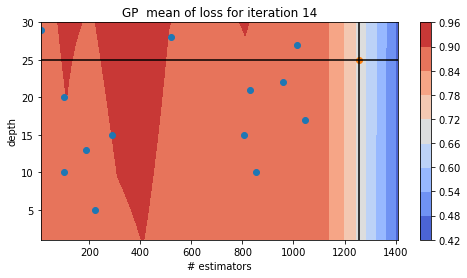

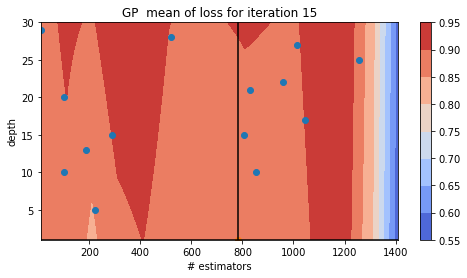

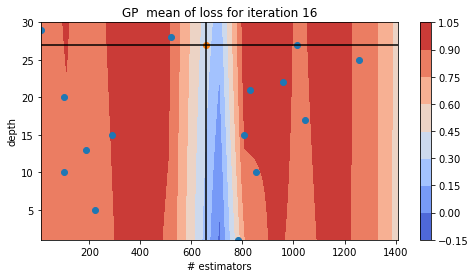

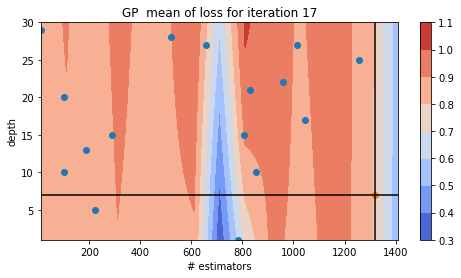

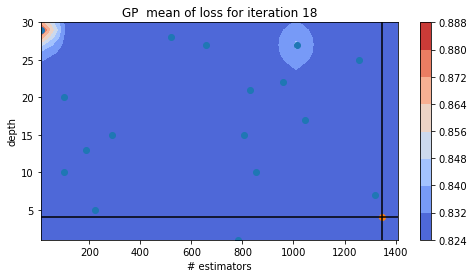

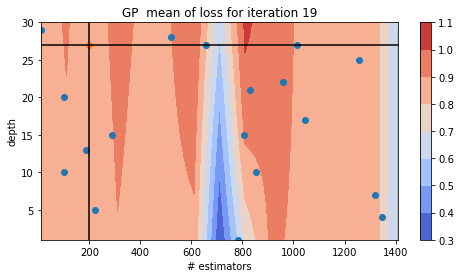

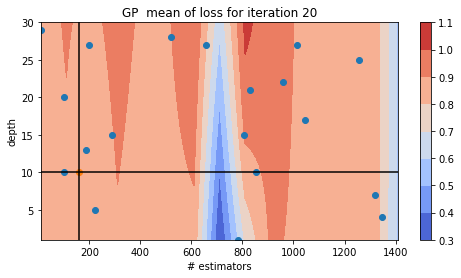

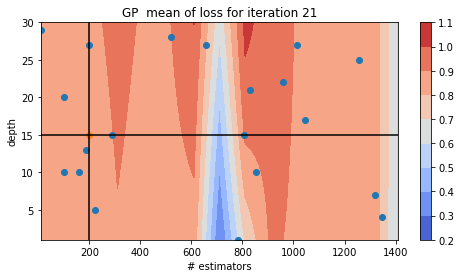

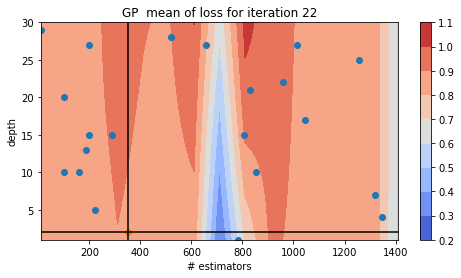

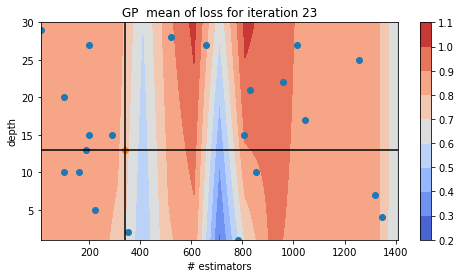

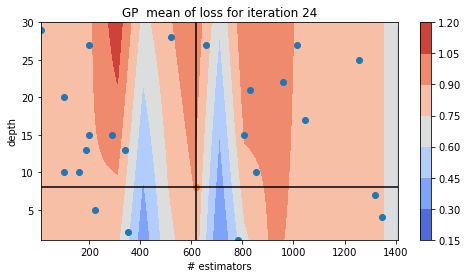

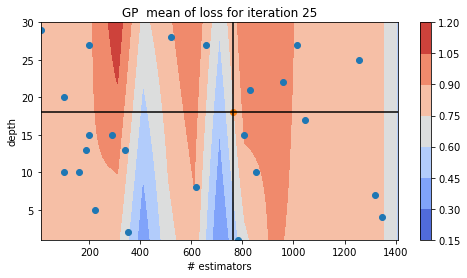

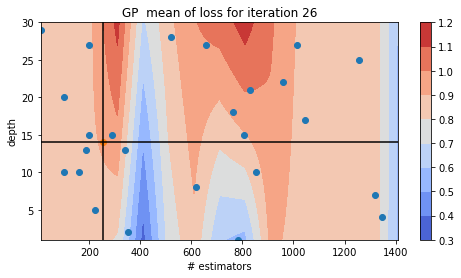

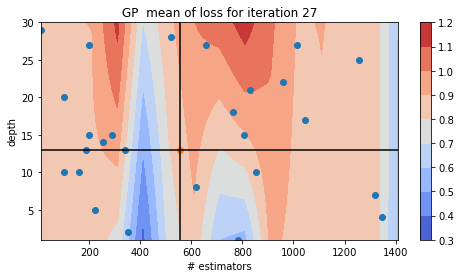

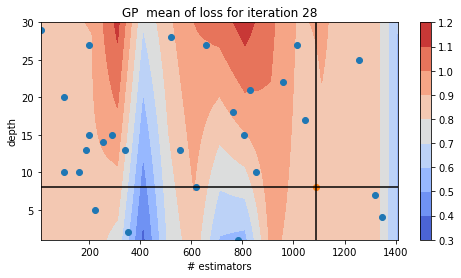

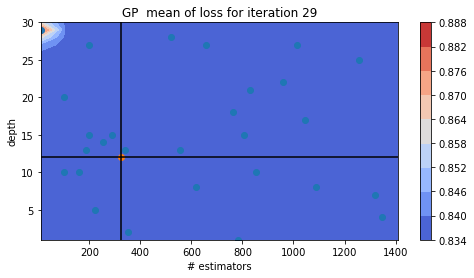

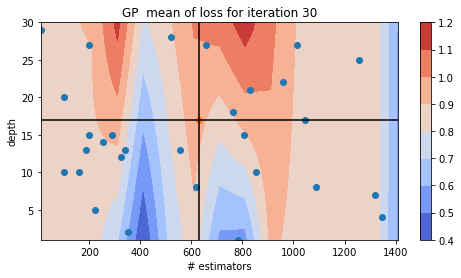

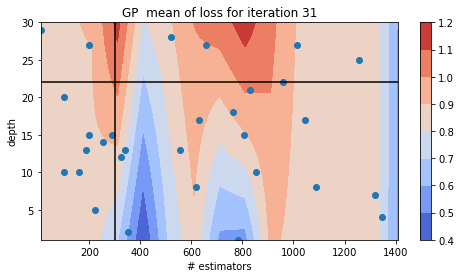

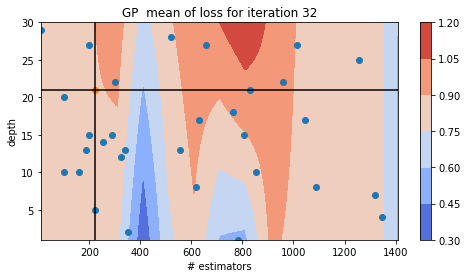

In [46]:
lambdas = np.arange(10, 1510, 100)
gammas = np.arange(1, 31, 1)
plot_iteration(lambdas, xp, yp, first_iter=4, second_param_grid=gammas)

In [13]:
from sklearn.datasets import make_classification

data, target = make_classification(n_samples=3000,
                                   n_features=20,
                                   n_informative=10,
                                   n_redundant=5)

In [14]:
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC

def sample_loss(params):
  C = params[0]
  gamma = params[1]


  # Sample parameters on a log scale
  return cross_val_score(SVC(C=10 ** C, gamma=10 ** gamma, random_state=1),
                         X=data,
                         y=target,
                         scoring='accuracy',
                         cv=3,
                         verbose=True).mean()

In [20]:
bounds = np.array([[3, 0], [1, -3]])

xp, yp = bp.bayesian_optimisation(n_iters=30, 
                               sample_loss=sample_loss, 
                               bounds=bounds,
                               n_pre_samples=3,
                               random_search=100000)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    2.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

C:\Users\kamcl\Miniconda3\envs\multistep_ml\lib\site-packages\ipykernel_launcher.py:97: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
C:\Users\kamcl\Miniconda3\envs\multistep_ml\lib\site-packages\ipykernel_launcher.py:97: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
C:\Users\kamcl\Miniconda3\envs\multistep_ml\lib\site-packages\ipykernel_launcher.py:97: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory.

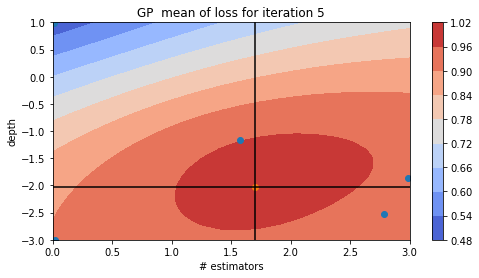

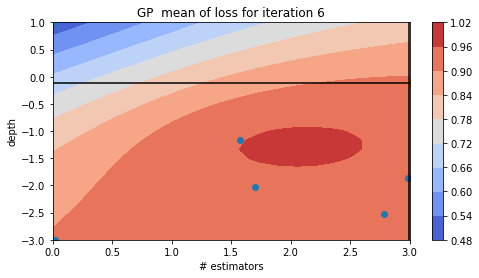

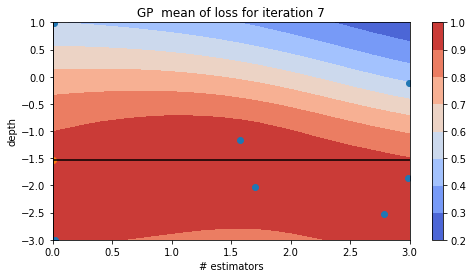

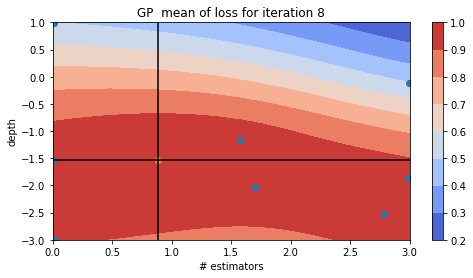

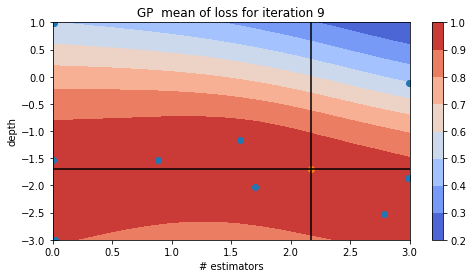

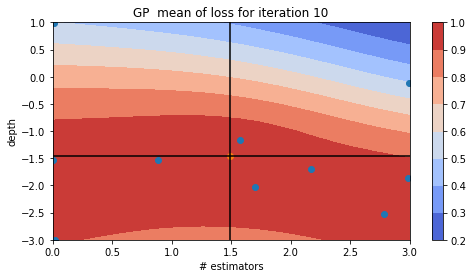

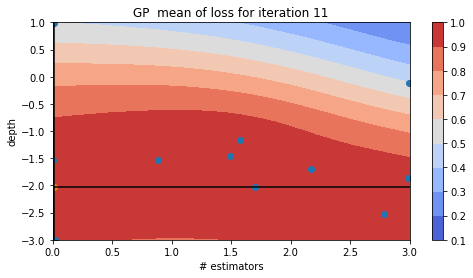

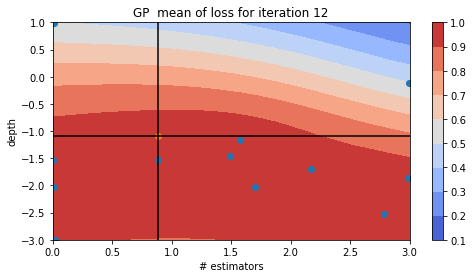

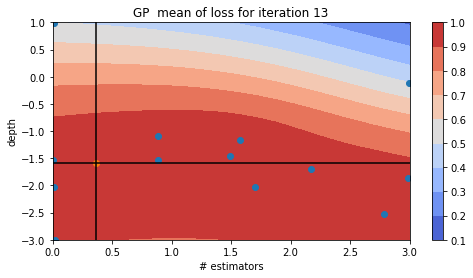

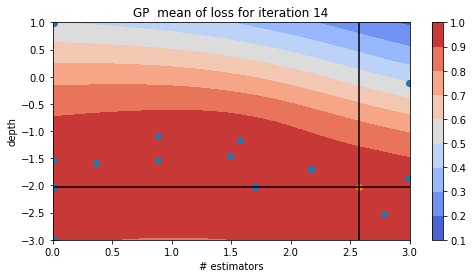

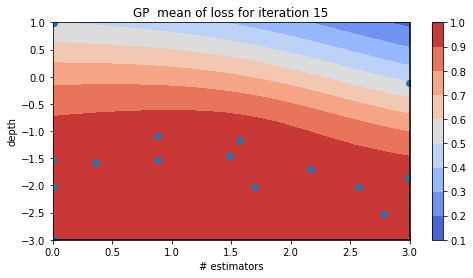

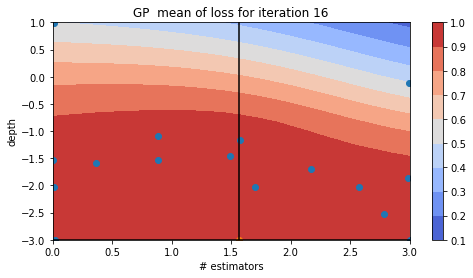

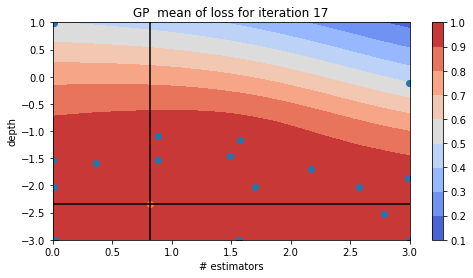

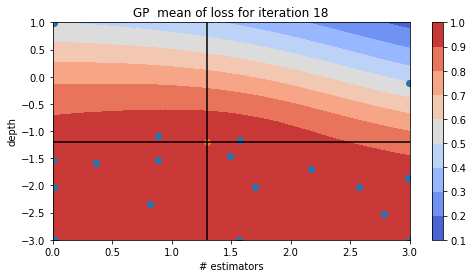

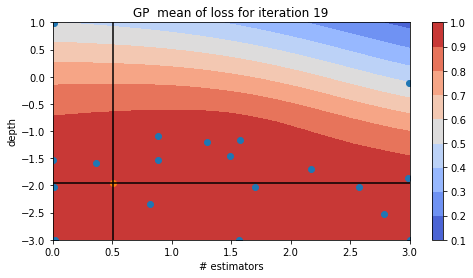

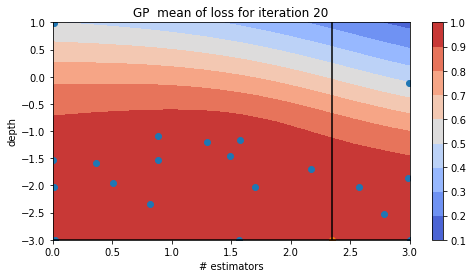

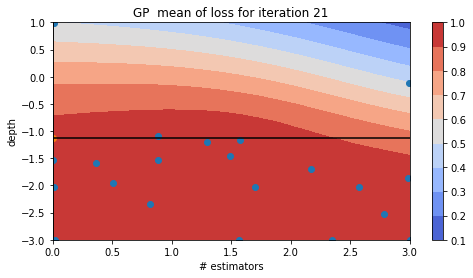

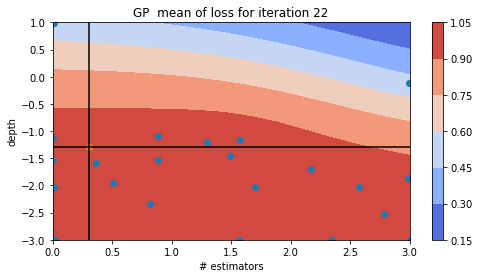

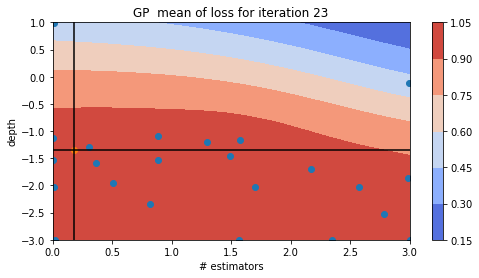

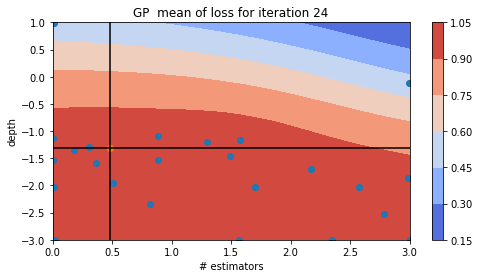

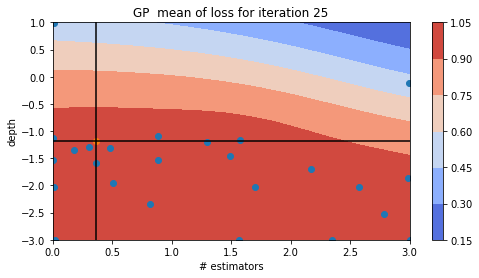

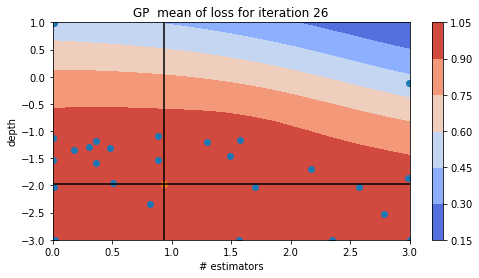

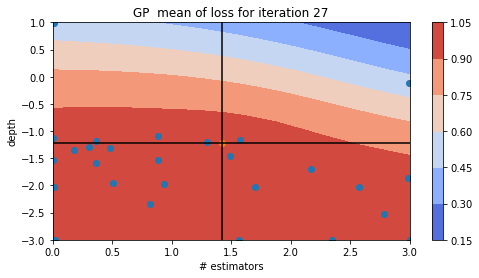

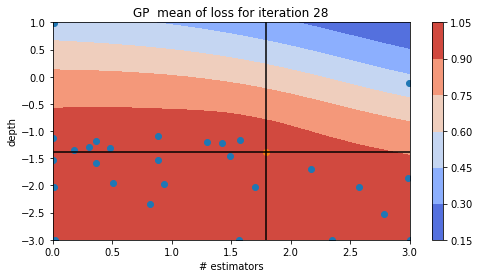

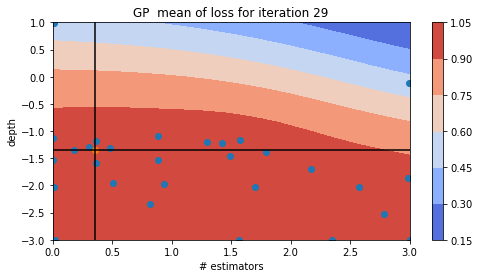

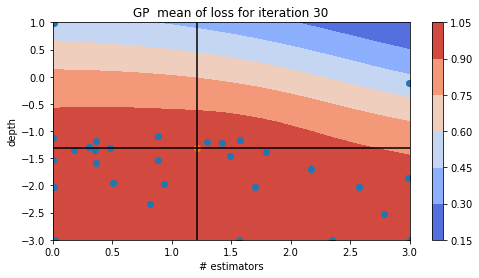

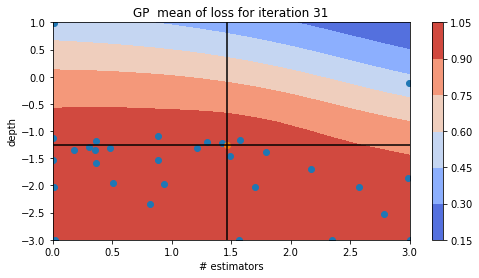

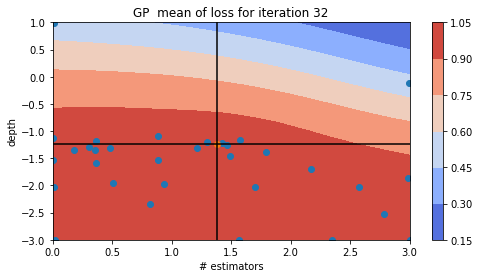

In [21]:
lambdas = np.linspace(3, 0, 20)
gammas = np.linspace(-3, 1, 25)
plot_iteration(lambdas, xp, yp, first_iter=4, second_param_grid=gammas)

In [22]:
import imageio
images = []

for i in range(6, 32):
    filename = path+"bo_iteration_%d.png" % i 
    images.append(imageio.imread(filename))
    
imageio.mimsave(path+'contour_plot.gif', images, duration=1.0)